In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import time
from collections import defaultdict
# from torch.utils.tensorboard import SummaryWriter
pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

GPU Available:  False


In [236]:

ue100 = pd.read_csv('data/ue_mali3_100_seed_44.csv')
cell100 = pd.read_csv('data/cell_mali3_100_seed_44.csv')
# only steps 25 or more
ue100_25 = ue100[ue100['step'] > 25]
cell100_25 = cell100[cell100['step'] > 25]
# reduce 25 from steps
ue100_25['step'] = ue100_25['step'] - 26
cell100_25['step'] = cell100_25['step'] - 26

t = get_dfs([ue100_25], [cell100_25])


In [237]:
t[0][t[0]['nrCellIdentity']==5]

,measPeriodPrb,throughput,DRB.UEThpDl,rsrp,rssinr,step,nrCellIdentity,ue-id
8,206,126.066666,25.284626,-61.454846,5.891433e+09,0,5,UE8
14,206,126.066666,25.155436,-62.217276,4.942856e+09,0,5,UE14
20,206,126.066666,25.303681,-56.969127,1.654980e+10,0,5,UE20
31,206,126.066666,25.051009,-62.286897,4.864249e+09,0,5,UE31
38,206,126.066666,25.271913,-57.602749,1.430312e+10,0,5,UE38
...,...,...,...,...,...,...,...,...
3497,175,101.287626,25.013792,-40.504818,7.332021e+11,71,5,UE47
3515,175,101.287626,25.323597,-72.510768,4.619859e+08,72,5,UE15
3517,175,101.287626,25.547257,-68.263663,1.228399e+09,72,5,UE17
3528,175,101.287626,25.402980,-73.798320,3.434579e+08,72,5,UE28


In [231]:
import pandas as pd

def marge_by_step(ue, cell, steps=60):
    dfs = []
    for s in range(steps):
        cell_s = cell[cell['step'] == s]
        ues_s = ue[ue['step'] == s]
        # Ensure that all rows from both dataframes are included
        merged_s = pd.merge(cell_s, ues_s, on='nrCellIdentity', how='outer')
        merged_s['step'] = s  # Ensure the 'step' column is consistent
        dfs.append(merged_s)
    return pd.concat(dfs, ignore_index=True)

# Example usage:
ue = pd.DataFrame({'nrCellIdentity': [1, 2, 3], 'step': [0, 1, 2], 'value': [10, 20, 30]})
cell = pd.DataFrame({'nrCellIdentity': [1, 2, 3, 4], 'step': [0, 1, 2, 2], 'data': [100, 200, 300, 400]})
result = marge_by_step(ue, cell, steps=3)
print(result)

   nrCellIdentity  step_x  data  step_y  value  step
0               1       0   100     0.0   10.0     0
1               2       1   200     1.0   20.0     1
2               3       2   300     2.0   30.0     2
3               4       2   400     NaN    NaN     2


In [221]:
t[0][t[0]['nrCellIdentity']==5]

,measPeriodPrb,throughput,DRB.UEThpDl,rsrp,rssinr,step,nrCellIdentity,ue-id
8,206,126.066666,25.284626,-61.454846,5.891433e+09,0,5,UE8
14,206,126.066666,25.155436,-62.217276,4.942856e+09,0,5,UE14
20,206,126.066666,25.303681,-56.969127,1.654980e+10,0,5,UE20
31,206,126.066666,25.051009,-62.286897,4.864249e+09,0,5,UE31
38,206,126.066666,25.271913,-57.602749,1.430312e+10,0,5,UE38
...,...,...,...,...,...,...,...,...
3497,175,101.287626,25.013792,-40.504818,7.332021e+11,71,5,UE47
3515,175,101.287626,25.323597,-72.510768,4.619859e+08,72,5,UE15
3517,175,101.287626,25.547257,-68.263663,1.228399e+09,72,5,UE17
3528,175,101.287626,25.402980,-73.798320,3.434579e+08,72,5,UE28


In [218]:
cell100_25[cell100_25["step"] > 14]

,time,availPrbDl,availPrbUl,measPeriodPdcpBytes,measPeriodPrb,measTimeStampRf,nrCellIdentity,pdcpBytesDl,pdcpBytesUl,step,throughput,x,y
246,2024-06-30T11:43:50.262314Z,79,29,64,405,2024-06-30 11:43:50.258014,1,2.272300e+02,2.272300e+02,15,2.272300e+02,250,300
247,2024-06-30T11:43:50.684221Z,13,64,28,85,2024-06-30 11:43:50.258046,2,5.018608e+01,5.018608e+01,15,5.018608e+01,500,125
248,2024-06-30T11:43:51.111951Z,26,9,90,1300,2024-06-30 11:43:50.258193,3,6.027938e+02,6.027938e+02,15,6.027938e+02,750,300
249,2024-06-30T11:43:51.545423Z,98,58,7,222,2024-06-30 11:43:50.258203,4,1.268330e+02,1.268330e+02,15,1.268330e+02,750,700
250,2024-06-30T11:43:51.972866Z,8,10,37,0,2024-06-30 11:43:50.258211,5,3.552714e-15,3.552714e-15,15,3.552714e-15,500,875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2024-06-30T12:22:47.861485Z,89,98,74,0,2024-06-30 12:22:47.431670,2,3.552714e-15,3.552714e-15,73,3.552714e-15,500,125
596,2024-06-30T12:22:48.283880Z,76,71,21,1300,2024-06-30 12:22:47.431863,3,5.771588e+02,5.771588e+02,73,5.771588e+02,750,300
597,2024-06-30T12:22:48.712878Z,67,77,52,218,2024-06-30 12:22:47.431879,4,1.269293e+02,1.269293e+02,73,1.269293e+02,750,700
598,2024-06-30T12:22:49.134383Z,16,9,34,175,2024-06-30 12:22:47.431890,5,1.012876e+02,1.012876e+02,73,1.012876e+02,500,875


In [212]:
from utils import features_extraction_new, get_dfs, create_idxs, scale_df
def decoder_evaluation(cell_id=0, data=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    res=[]
    ue_test_mali = pd.read_csv(f'data/ue_mali{cell_id}_seed_8.csv')
    cell_test_mali = pd.read_csv(f'data/cell_mali{cell_id}_seed_8.csv')
    if data is not None:
        ue_test_mali = data[0]
        cell_test_mali = data[1]

    # process
    mali_dfs = get_dfs([ue_test_mali], [cell_test_mali])
    res.append(mali_dfs)
    # extract features
    mali_dfs = features_extraction_new(mali_dfs, only_cell=False, single_cell=False)
    # create indexes for evaluation
    res.append(mali_dfs)
    mali_test = create_idxs(mali_dfs, win_size=3, only_cell=False)
    res.append(mali_test)
    
    return res
    
    



ue100 = pd.read_csv('data/ue_mali3_100_seed_44.csv')
cell100 = pd.read_csv('data/cell_mali3_100_seed_44.csv')
# only steps 25 or more
ue100_25 = ue100[ue100['step'] > 25]
cell100_25 = cell100[cell100['step'] > 25]
# reduce 25 from steps
ue100_25['step'] = ue100_25['step'] - 26
cell100_25['step'] = cell100_25['step'] - 26


d = decoder_evaluation(3, [ue100_25, cell100_25])


max step [72]


In [213]:

d[2]

,step,nrCellIdentity,measPeriodPrb_mean,measPeriodPrb_std,throughput_mean,throughput_std,DRB.UEThpDl_mean,DRB.UEThpDl_std,rsrp_mean,rsrp_std,rssinr_mean,rssinr_std,new_ue_count,left_ue_count,ue_count,idx
0,0,1,315.0,0.0,177.020333,0.0,25.288619,0.167594,-66.095822,9.112653,1.597742e+10,3.525826e+10,7,0,7,0
1,1,1,315.0,0.0,177.020333,0.0,25.288619,0.167594,-66.059315,9.494219,1.938170e+10,4.408937e+10,0,0,7,0
2,2,1,315.0,0.0,177.020333,0.0,25.288619,0.167594,-65.930602,9.831638,2.381769e+10,5.562348e+10,0,0,7,0
3,0,2,246.0,0.0,151.059693,0.0,25.176615,0.168337,-62.152871,3.631241,6.429296e+09,4.398829e+09,6,0,6,1
4,1,2,246.0,0.0,151.059693,0.0,25.176615,0.168337,-62.500758,3.482761,5.805497e+09,3.762537e+09,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,72,4,218.0,0.0,126.929256,0.0,25.385851,0.166238,-58.603690,10.330949,1.089394e+11,2.267970e+11,0,1,5,500
1173,71,5,175.0,0.0,101.287626,0.0,25.321907,0.225310,-63.620288,15.601330,1.838373e+11,3.662435e+11,0,0,4,501
1174,72,5,175.0,0.0,101.287626,0.0,25.321907,0.225310,-64.004139,15.224991,1.481693e+11,2.949829e+11,0,0,4,501
1175,71,6,411.0,0.0,227.821430,0.0,25.313492,0.162978,-58.525230,8.953664,6.968383e+10,1.545916e+11,0,0,9,502


In [197]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Example data
data = {'A': [1, 2, 3, 4, 5],
        'B': [10, 20, 30, 40, 50],
        'C': [100, 200, 300, 400, 500]}
df = pd.DataFrame(data)

# Standardization
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

print(df_scaled)

          A         B         C
0 -1.414214 -1.414214 -1.414214
1 -0.707107 -0.707107 -0.707107
2  0.000000  0.000000  0.000000
3  0.707107  0.707107  0.707107
4  1.414214  1.414214  1.414214


# Load data

In [174]:
ue0 = pd.read_csv('data/ue.csv')
cell0 = pd.read_csv('data/cell.csv')
fix_steps = []
for i in range(60):
    fix_steps+=[i,i,i,i,i,i]
cell0['step'] = fix_steps

ue1 = pd.read_csv('data/ue_norm_seed_1.csv')
cell1 = pd.read_csv('data/cell_norm_seed_1.csv')

fix_steps = []
for i in range(58):
    fix_steps+=[i]*50
ue1['step'] = fix_steps

ue2 = pd.read_csv('data/ue_norm_seed_2.csv')
cell2 = pd.read_csv('data/cell_norm_seed_1.csv')

ue3 = pd.read_csv('data/ue_norm_seed_3.csv')
cell3 = pd.read_csv('data/cell_norm_seed_3.csv')

ue4 = pd.read_csv('data/ue_norm_seed_4.csv')
cell4 = pd.read_csv('data/cell_norm_seed_4.csv')

ue5 = pd.read_csv('data/ue_norm_seed_5.csv')
cell5 = pd.read_csv('data/cell_norm_seed_5.csv')

ue6 = pd.read_csv('data/ue_norm_seed_6.csv')
cell6 = pd.read_csv('data/cell_norm_seed_6.csv')

ue7 = pd.read_csv('data/ue_norm_seed_7.csv')
cell7 = pd.read_csv('data/cell_norm_seed_7.csv')

# evaluation data

ue8 = pd.read_csv('data/ue_norm_seed_8.csv')
cell8 = pd.read_csv('data/cell_norm_seed_8.csv')

fix_steps = []
for i in range(62):
    fix_steps+=[i]*50

ue_m = pd.read_csv('data/ue_mali5_2805.csv')
cell_m = pd.read_csv('data/cell_mali5_2805.csv')
ue_m['step'] = fix_steps

ue_m2 = pd.read_csv('data/ue_mali_seed_2.csv')
cell_m2 = pd.read_csv('data/cell_mali5_seed_2.csv')

ue70 = pd.read_csv('data/ue_norm70_seed_42.csv')
cell70 = pd.read_csv('data/cell_norm70_seed_42.csv')

ues = [ue70, ue0, ue2, ue3, ue4, ue5, ue6, ue7, ue_m, ue_m2]
cells = [cell70, cell0, cell2, cell3, cell4, cell5, cell6, cell7, cell_m, cell_m2]
# normal_ue_eval = [ue8]
# normal_cell_eval = [cell8]

In [178]:
# convert ue-id col from 'UE1' to int 1
for i in range(len(ues)):
    ues[i]['ue-id'] = ues[i]['ue-id'].apply(lambda x: int(x[2:]))


# Preprocessing

In [179]:
def update_cols(ue, cell):
    ues_cols = [
          'DRB.UEThpDl', 'RF.serving.RSRP', 'RF.serving.RSSINR',
          'nrCellIdentity',
          'rsrp_nb0', 'rsrp_nb1', 'rsrp_nb2', 'rsrp_nb3', 'rsrp_nb4',
          'rssinr_nb0', 'rssinr_nb1', 'rssinr_nb2', 'rssinr_nb3', 'rssinr_nb4',
          'step', 'targetTput', 'x', 'y', 'ue-id']

    cells_cols = [
          'measPeriodPrb', 'nrCellIdentity', 'pdcpBytesDl',
          'pdcpBytesUl', 'step', 'throughput', 'x', 'y']

    ue = ue[ues_cols]
    cell = cell[cells_cols]
    return ue, cell

def marge_by_step(ue, cell, steps=60, debug=False):
    dfs = []
    for s in range(steps):
        cell_s = cell[cell['step'] == s]
        ues_s = ue[ue['step'] == s]
        merged_s = pd.merge(ues_s, cell_s, on='nrCellIdentity', how='left')
        merged_s.drop(columns=['step_x'], inplace=True)
        dfs.append(merged_s)
    return pd.concat(dfs, ignore_index=True)

def get_dfs(ues, cells):
    res = []
    metrics = ['measPeriodPrb', 'throughput', 'DRB.UEThpDl', 'RF.serving.RSRP', 'RF.serving.RSSINR', 'step_y','nrCellIdentity','ue-id']
    for i in range(len(ues)):
        u, c = update_cols(ues[i], cells[i])
        curr = marge_by_step(u, c)[metrics].rename(columns={'step_y': 'step', 'RF.serving.RSRP': 'rsrp', 'RF.serving.RSSINR': 'rssinr'})
        res.append(curr)
    return res

def create_idxs(dfs, win_size=3, only_cell=False):
    print("Creating indexes")
    lst = []
    win = win_size
    counter = 0
    max_cells=max(dfs[0]['nrCellIdentity'])+1
    for s in range(max(dfs[0]['step'])):
        for cell in range(1, max_cells+1):
            
            if only_cell:
                if cell != only_cell:
                    continue
            
            for j, df in enumerate(dfs):    
                for w in range(win):
                    df_cell = df[df['nrCellIdentity']==cell]
                    try:
                        df_cell_step = df_cell[df_cell['step'] == s+w]
                        df_cell_step['idx'] = [int(counter)]*df_cell_step.shape[0]
                        lst.append(df_cell_step)
                    except:
                        print("-------------------")
                        print(df_cell[df_cell['step'] == s+w])
                        print("-------------------")
                        continue
                counter+=1
    concat_df = pd.concat(lst, ignore_index=True)
    concat_df['idx'] = concat_df['idx'].astype(int)
    return concat_df

def scale_df(df, test=False, scaler=None):
    # print(df)
    data = df.drop(columns=['step', 'nrCellIdentity', 'idx'], inplace=False)
    if test == False:
    # print(data)
        scaler = StandardScaler()
        scaler.fit(data)
    scale_data = scaler.transform(data)
    scaled_df = pd.DataFrame(scale_data, columns=data.columns)
    scaled_df['step'] = df['step']
    scaled_df['nrCellIdentity'] = df['nrCellIdentity']
    scaled_df['idx'] = df['idx']
    return scaled_df, scaler

def get_cell_only(df_lst):
    res = []
    for df in df_lst:
        res.append(df)
    return res

dfs = get_dfs(ues, cells)


In [166]:
ue2[ue2['step']>=15]

,time,DRB.UEThpDl,RF.serving.RSRP,RF.serving.RSRQ,RF.serving.RSSINR,RRU.PrbUsedDl,Viavi.UE.anomalies,measTimeStampRf,nbCellIdentity_0,nbCellIdentity_1,...,rssinr_nb0,rssinr_nb1,rssinr_nb2,rssinr_nb3,rssinr_nb4,step,targetTput,ue-id,x,y
700,2024-05-29T10:09:09.826457Z,25.216334,-52.565853,-40.0,4.561632e+10,58.959669,0,2024-05-29 10:09:09.809393,1.0,3.0,...,2.606592e+08,6.602899e+08,4.656425e+01,97.251033,48.586021,15,40.711699,0,556.528803,74.625089
701,2024-05-29T10:09:10.588117Z,25.066821,-65.007855,-40.0,2.599681e+09,68.575451,0,2024-05-29 10:09:09.809513,4.0,5.0,...,5.987469e+08,2.755617e+09,8.783365e+01,71.003599,50.465732,15,79.879179,1,450.106218,704.641254
702,2024-05-29T10:09:11.338057Z,25.500130,-54.607798,-40.0,2.850531e+10,62.306431,0,2024-05-29 10:09:09.809578,4.0,NaN,...,3.915013e+08,8.927521e+01,7.257654e+01,70.683387,75.363756,15,70.176346,2,820.328817,368.666480
703,2024-05-29T10:09:12.072027Z,25.143868,-68.995791,-40.0,1.037831e+09,20.002883,1,2024-05-29 10:09:09.809634,6.0,NaN,...,7.760239e+09,4.881282e+01,9.160014e+01,21.704172,46.796166,15,62.864199,3,233.150047,555.573323
704,2024-05-29T10:09:12.812786Z,25.442517,-67.462276,-40.0,1.477331e+09,23.402196,0,2024-05-29 10:09:09.809687,1.0,4.0,...,1.171637e+01,1.394321e+00,2.605360e+08,57.605443,62.164561,15,84.513851,4,417.878537,534.600551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,2024-05-29T10:39:40.209945Z,0.000000,-48.927643,-40.0,1.054244e+11,31.820811,0,2024-05-29 10:39:06.765607,5.0,NaN,...,6.278061e+08,2.602440e+01,8.887993e+01,40.665687,70.751023,59,72.267804,45,251.266494,764.460294
2946,2024-05-29T10:39:40.949878Z,0.000000,-65.473281,-40.0,2.335487e+09,87.899655,1,2024-05-29 10:39:06.765657,NaN,NaN,...,7.986514e+01,8.588152e+01,7.481164e+01,58.159521,11.565786,59,77.934712,46,44.651741,678.496304
2947,2024-05-29T10:39:41.681062Z,25.346707,-65.373939,-8.0,2.389526e+09,70.823266,0,2024-05-29 10:39:06.765702,NaN,NaN,...,9.807668e+01,2.247459e+01,2.915686e+01,49.495005,4.087621,59,56.003087,47,74.004385,202.194417
2948,2024-05-29T10:39:42.420813Z,25.022220,-74.676231,-40.0,5.012437e+00,50.719655,1,2024-05-29 10:39:06.765751,4.0,5.0,...,2.328385e+00,7.904305e+08,4.637322e+09,35.626727,82.974237,59,87.126687,48,407.255820,637.723635


In [182]:
dfs[0][dfs[0]['nrCellIdentity'] == 3][["step", "ue-id"]]

,step,ue-id
6,0,6
7,0,7
12,0,12
27,0,27
32,0,32
...,...,...
2958,59,8
2970,59,20
2977,59,27
2982,59,32


In [198]:
# dfs[1][dfs[1]['nrCellIdentity']==5]
dfs[1]

,step,nrCellIdentity,measPeriodPrb_mean,measPeriodPrb_std,throughput_mean,throughput_std,DRB.UEThpDl_mean,DRB.UEThpDl_std,rsrp_mean,rsrp_std,rssinr_mean,rssinr_std,new_ue_count,left_ue_count,ue_count
4,0,5,250.0,0.0,151.816246,0.0,25.302708,0.193830,-57.094380,8.785186,1.127289e+11,2.471104e+11,6,0,6
10,1,5,250.0,0.0,151.816246,0.0,25.302708,0.193830,-57.239131,8.451493,1.009171e+11,2.208571e+11,0,0,6
16,2,5,250.0,0.0,151.816246,0.0,25.302708,0.193830,-57.407825,8.066118,8.687964e+10,1.885846e+11,0,0,6
22,3,5,250.0,0.0,151.816246,0.0,25.302708,0.193830,-57.591987,7.647414,7.275320e+10,1.555913e+11,0,0,6
28,4,5,250.0,0.0,151.816246,0.0,25.302708,0.193830,-57.783486,7.215310,5.994574e+10,1.253760e+11,0,0,6
34,5,5,250.0,0.0,151.816246,0.0,25.302708,0.193830,-57.975430,6.789094,4.910308e+10,9.955699e+10,0,0,6
40,6,5,250.0,0.0,151.816246,0.0,25.302708,0.193830,-58.373664,6.651725,4.021090e+10,7.850161e+10,0,0,6
46,7,5,250.0,0.0,151.816246,0.0,25.302708,0.193830,-58.566840,6.321392,3.334034e+10,6.166683e+10,0,0,6
52,8,5,250.0,0.0,151.816246,0.0,25.302708,0.193830,-58.747558,6.046274,2.809677e+10,4.845900e+10,0,0,6
58,9,5,250.0,0.0,151.816246,0.0,25.302708,0.193830,-58.913914,5.838532,2.420034e+10,3.822026e+10,0,0,6


# Features extraction

In [183]:
# aggregate for every cell and step avg values 'measPeriodPrb', 'throughput', 'DRB.UEThpDl', 'RF.serving.RSRP', 'RF.serving.RSSINR' and count num of rows was agregated
dfs = get_dfs(ues, cells)
flag = set([i for i in range(50)]) == set(dfs[1]['ue-id'].unique())
print(f"all ue in df: {flag}")
# def features_extraction(dfs, only_cell=False, single_cell=False):
#     for i in range(len(dfs)):
#         ue_count = dfs[i].groupby(['step', 'nrCellIdentity']).count().reset_index()['DRB.UEThpDl']
#         new_ue_counts = []
#         left_ue_counts = []
# 
#         for cell, group in dfs[i].groupby('nrCellIdentity'):
#             seen_ues = set()
#             previous_step_ues = set()
#             for step, ues in group.groupby('step')['ue-id']:
#                 current_step_ues = set(ues)
#                 # New UEs
#                 new_ues = current_step_ues - seen_ues if step != 0 else set()
#                 new_ue_counts.append({'step': step, 'nrCellIdentity': cell, 'new_ue_count': len(new_ues)})
#                 # UEs that have left
#                 left_ues = previous_step_ues - current_step_ues if step != 0 else set() 
#                 left_ue_counts.append({'step': step, 'nrCellIdentity': cell, 'left_ue_count': len(left_ues)})
# 
#                 seen_ues.update(new_ues)
#                 previous_step_ues = current_step_ues
# 
#         new_ue_df = pd.DataFrame(new_ue_counts)
#         left_ue_df = pd.DataFrame(left_ue_counts)
#         
#         dfs[i] = dfs[i].merge(new_ue_df, on=['step', 'nrCellIdentity'], how='left')
#         dfs[i] = dfs[i].merge(left_ue_df, on=['step', 'nrCellIdentity'], how='left')
#         # Drop ue-id column
#         dfs[i] = dfs[i].drop(columns=['ue-id'])
#         
#         
#         # Calculate mean and std
#         agg_funcs = {col: ['mean', 'std'] for col in dfs[i].columns if col not in ['step', 'nrCellIdentity', 'new_ue_count', 'left_ue_count']}
#         grouped = dfs[i].groupby(['step', 'nrCellIdentity']).agg(agg_funcs).reset_index()
#         
#         # Flatten the MultiIndex columns
#         grouped.columns = ['_'.join(col).rstrip('_') for col in grouped.columns]
#         print(grouped.columns)
#         dfs[i] = grouped
#         
#         dfs[i]['ue_count'] = ue_count
#         
#         
#         if single_cell:
#             dfs[i] = dfs[i][dfs[i]['nrCellIdentity'] == single_cell]
#     
#         return dfs
    

def features_extraction(dfs, only_cell=False, single_cell=False):
    for i in range(len(dfs)):
        # Count UEs
        ue_count = dfs[i].groupby(['step', 'nrCellIdentity']).count().reset_index()['DRB.UEThpDl']
        new_ue_counts = []
        left_ue_counts = []
            
        for cell, group in dfs[i].groupby('nrCellIdentity'):
            # seen_ues = set()
            previous_step_ues = set()
            # print(group)
            for step, ues in group.groupby('step')['ue-id']:
                current_step_ues = set(ues)
                
                new_ues = current_step_ues - previous_step_ues
                left_ues = previous_step_ues - current_step_ues 

                new_ue_counts.append({'step': step, 'nrCellIdentity': cell, 'new_ue_count': len(new_ues)})
                left_ue_counts.append({'step': step, 'nrCellIdentity': cell, 'left_ue_count': len(left_ues)})

                # seen_ues.update(new_ues)
                
                if i == 5 and cell == 5:
                    if step in [30, 31, 32]:
                        print(f"step: {step} | cell: {cell} | current: {current_step_ues} | prev: {previous_step_ues}")
                        print(f"new: {new_ues} | left: {left_ues}")
                
                previous_step_ues = current_step_ues

        new_ue_df = pd.DataFrame(new_ue_counts)
        left_ue_df = pd.DataFrame(left_ue_counts)

        # Merge new and left UE counts back into the original dataframe
        dfs[i] = dfs[i].merge(new_ue_df, on=['step', 'nrCellIdentity'], how='left')
        dfs[i] = dfs[i].merge(left_ue_df, on=['step', 'nrCellIdentity'], how='left')

        # Calculate mean and std
        agg_funcs = {col: ['mean', 'std'] for col in dfs[i].columns if col not in ['step', 'nrCellIdentity', 'new_ue_count', 'left_ue_count', 'ue-id']}
        grouped = dfs[i].groupby(['step', 'nrCellIdentity']).agg(agg_funcs).reset_index()

        # Flatten the MultiIndex columns
        grouped.columns = ['_'.join(col).rstrip('_') for col in grouped.columns]

        # Merge the new and left UE counts back to the grouped dataframe
        grouped = grouped.merge(new_ue_df, on=['step', 'nrCellIdentity'], how='left')
        grouped = grouped.merge(left_ue_df, on=['step', 'nrCellIdentity'], how='left')

        # Add the ue_count back
        grouped['ue_count'] = ue_count

        dfs[i] = grouped

        # Filter by single cell if specified
        if single_cell:
            dfs[i] = dfs[i][dfs[i]['nrCellIdentity'] == single_cell]

    return dfs
    # for i in range(len(dfs)):
    #     dfs[i] = dfs[i].sort_values(by=['nrCellIdentity', 'step'])
    #     dfs[i]['prev_ue_count'] = dfs[i].groupby('nrCellIdentity')['ue_count'].shift(1)
    #     dfs[i]['new_ues'] = dfs[i]['ue_count'] - dfs[i]['prev_ue_count']
    #     dfs[i]['new_ues'] = dfs[i]['new_ues'].fillna(0).astype(int)
    #     dfs[i] = dfs[i].drop(columns=['prev_ue_count'])
    #     dfs[i] = dfs[i].sort_values(by=['step', 'nrCellIdentity'])
    # 
    # if only_cell:
    #     for i in range(len(dfs)):
    #         dfs[i] = dfs[i].drop(columns=['rsrp', 'rssinr', 'DRB.UEThpDl'])
    # if single_cell != False:
    #     for i in range(len(dfs)):
    #         dfs[i] = dfs[i][dfs[i]['nrCellIdentity']==single_cell]
    # return dfs

only_cell = False
cell_id = 5
dfs_e = features_extraction(dfs, only_cell=only_cell, single_cell=cell_id)
### evaluation
# norm_eval = get_dfs(normal_ue_eval, normal_cell_eval)
# norm_eval = features_extraction(norm_eval, only_cell=only_cell, single_cell=1)

all ue in df: True
step: 30 | cell: 5 | current: {35, 6} | prev: {35, 6}
new: set() | left: set()
step: 31 | cell: 5 | current: {35, 6} | prev: {35, 6}
new: set() | left: set()
step: 32 | cell: 5 | current: {35, 6} | prev: {35, 6}
new: set() | left: set()


In [185]:
dfs[0]
# dfs_e[1]["step"].unique()

,step,nrCellIdentity,measPeriodPrb_mean,measPeriodPrb_std,throughput_mean,throughput_std,DRB.UEThpDl_mean,DRB.UEThpDl_std,rsrp_mean,rsrp_std,rssinr_mean,rssinr_std,new_ue_count,left_ue_count,ue_count
4,0,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-58.010503,3.901055,1.775560e+10,1.395620e+10,6,0,6
10,1,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-58.374472,3.628823,1.574870e+10,1.191141e+10,0,0,6
16,2,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-58.730224,3.389004,1.404055e+10,1.011651e+10,0,0,6
22,3,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-59.370166,3.705176,1.238955e+10,8.830338e+09,0,0,6
28,4,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-59.703228,3.577053,1.120715e+10,7.499599e+09,0,0,6
34,5,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-59.962129,3.379558,1.027208e+10,6.374211e+09,0,0,6
40,6,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-60.189532,3.204472,9.541753e+09,5.529533e+09,0,0,6
46,7,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-60.406855,3.105896,8.991010e+09,5.063464e+09,0,0,6
52,8,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-60.613860,3.092273,8.611618e+09,5.067123e+09,0,0,6
58,9,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-60.810363,3.166117,8.401273e+09,5.581640e+09,0,0,6


In [186]:
def create_idx_only_cell(dfs, win_size=3, only_cell=False):
    print("Creating indexes")
    dfs_by_cell = [df[df['nrCellIdentity']==only_cell] for df in dfs]
    lst = []
    win = win_size
    start_from = 0
    for j, df in enumerate(dfs_by_cell):
        for s in range(max(df['step'])-win+1):
            for w in range(win):
                if start_from == 107:
                    print("#################")
                    print(f"step:{s} | win:{w} | df: {j}")
                    print('#################')
                df_cell_step = df[df['step'] == s+w]
                df_cell_step['idx'] = [int(start_from)]*df_cell_step.shape[0]
                lst.append(df_cell_step)
            start_from+=1
    concat_df = pd.concat(lst, ignore_index=True)
    concat_df['idx'] = concat_df['idx'].astype(int)
    return concat_df
    
# def create_idxs(dfs, win_size=3, only_cell=False):
#     print("Creating indexes")
#     lst = []
#     win = win_size
#     counter = 0
#     max_cells=max(dfs[0]['nrCellIdentity'])+1
#     
#     
#     for s in range(max(dfs[0]['step'])):
#         for cell in range(1, max_cells+1):
#             
#             if only_cell:
#                 if cell != only_cell:
#                     continue
#             
#             for j, df in enumerate(dfs):    
#                 for w in range(win):
#                     if int(counter) == 377:
#                         print("#################")
#                         print(f"s {s} w {w} cell {cell}, j {j}")
#                     df_cell = df[df['nrCellIdentity']==cell]
#                     df_cell_step = df_cell[df_cell['step'] == s+w]
#                     df_cell_step['idx'] = [int(counter)]*df_cell_step.shape[0]
#                     lst.append(df_cell_step)
#                     # except:
#                     #     print(df_cell[df_cell['step'] == s+w])
#                     #     continue
#                 counter+=1
#     concat_df = pd.concat(lst, ignore_index=True)
#     concat_df['idx'] = concat_df['idx'].astype(int)
#     return concat_df
size = 8
train = create_idx_only_cell(dfs[:size],win_size=3,only_cell=cell_id)

# Counter(train['idx'])
train[train['idx']==107] 

Creating indexes
#################
step:50 | win:0 | df: 1
#################
#################
step:50 | win:1 | df: 1
#################
#################
step:50 | win:2 | df: 1
#################


,step,nrCellIdentity,measPeriodPrb_mean,measPeriodPrb_std,throughput_mean,throughput_std,DRB.UEThpDl_mean,DRB.UEThpDl_std,rsrp_mean,rsrp_std,rssinr_mean,rssinr_std,new_ue_count,left_ue_count,ue_count,idx
321,50,5,86.0,0.0,50.370969,0.0,25.185485,0.148611,-58.682881,2.586188,1.215716e+10,6.839936e+09,1,0,2,107
322,51,5,86.0,0.0,50.370969,0.0,25.185485,0.148611,-58.490658,2.142071,1.237469e+10,5.867570e+09,0,0,2,107
323,52,5,86.0,0.0,50.370969,0.0,25.185485,0.148611,-58.307372,1.667886,1.261214e+10,4.727974e+09,0,0,2,107


In [191]:
train

,step,nrCellIdentity,measPeriodPrb_mean,measPeriodPrb_std,throughput_mean,throughput_std,DRB.UEThpDl_mean,DRB.UEThpDl_std,rsrp_mean,rsrp_std,rssinr_mean,rssinr_std,new_ue_count,left_ue_count,ue_count,idx
0,0,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-58.010503,3.901055,1.775560e+10,1.395620e+10,6,0,6,0
1,1,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-58.374472,3.628823,1.574870e+10,1.191141e+10,0,0,6,0
2,2,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-58.730224,3.389004,1.404055e+10,1.011651e+10,0,0,6,0
3,1,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-58.374472,3.628823,1.574870e+10,1.191141e+10,0,0,6,1
4,2,5,250.0,0.0,151.300502,0.0,25.216750,0.197635,-58.730224,3.389004,1.404055e+10,1.011651e+10,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,56,5,403.0,0.0,227.151495,0.0,25.239055,0.161825,-63.971449,6.304772,6.690023e+09,6.122592e+09,2,0,9,420
1259,57,5,403.0,0.0,227.151495,0.0,25.239055,0.161825,-64.087456,6.172460,6.397374e+09,5.881638e+09,0,0,9,420
1260,56,5,403.0,0.0,227.151495,0.0,25.239055,0.161825,-63.971449,6.304772,6.690023e+09,6.122592e+09,2,0,9,421
1261,57,5,403.0,0.0,227.151495,0.0,25.239055,0.161825,-64.087456,6.172460,6.397374e+09,5.881638e+09,0,0,9,421


In [190]:
train[train['idx']==500]

,step,nrCellIdentity,measPeriodPrb_mean,measPeriodPrb_std,throughput_mean,throughput_std,DRB.UEThpDl_mean,DRB.UEThpDl_std,rsrp_mean,rsrp_std,rssinr_mean,rssinr_std,new_ue_count,left_ue_count,ue_count,idx


In [21]:
size = 8
len(dfs[:size]), len(dfs[size:]), len(dfs)

(8, 2, 10)

In [92]:
train, test, = create_idxs(dfs[:size],win_size=3,only_cell=cell_id), create_idxs(dfs[size:],win_size=3,only_cell=cell_id) 
train, scaler = scale_df(train)
test, _ = scale_df(test, test=True, scaler=scaler)
train.shape, test.shape
train.head()

Creating indexes
Creating indexes


,measPeriodPrb,throughput,DRB.UEThpDl,rsrp,rssinr,ue_count,new_ues,step,nrCellIdentity,idx
0,0.872063,0.917707,-0.444736,0.344730,0.601188,1.001830,0.019376,0,5,0
1,0.872063,0.917707,-0.444736,0.307181,0.465088,1.001830,0.019376,1,5,0
2,0.872063,0.917707,-0.444736,0.263420,0.303343,1.001830,0.019376,2,5,0
3,0.006206,-0.026248,-0.921051,-0.395402,-0.489464,0.082478,0.019376,0,5,1
4,0.006206,-0.026248,-0.425949,-0.653520,-0.520538,-0.377198,-1.499181,1,5,1


In [28]:

# norm_test = create_idxs(norm_eval, win_size=3, only_cell=5)
# norm_test, _ = scale_df(norm_test, test=True, scaler=scaler)
# print(len(train), len(test), len(norm_test))

,measPeriodPrb,throughput,DRB.UEThpDl,rsrp,rssinr,ue_count,new_ues,step,nrCellIdentity,idx


In [195]:
len(set(range(1263)) - set(train["idx"]))  

841

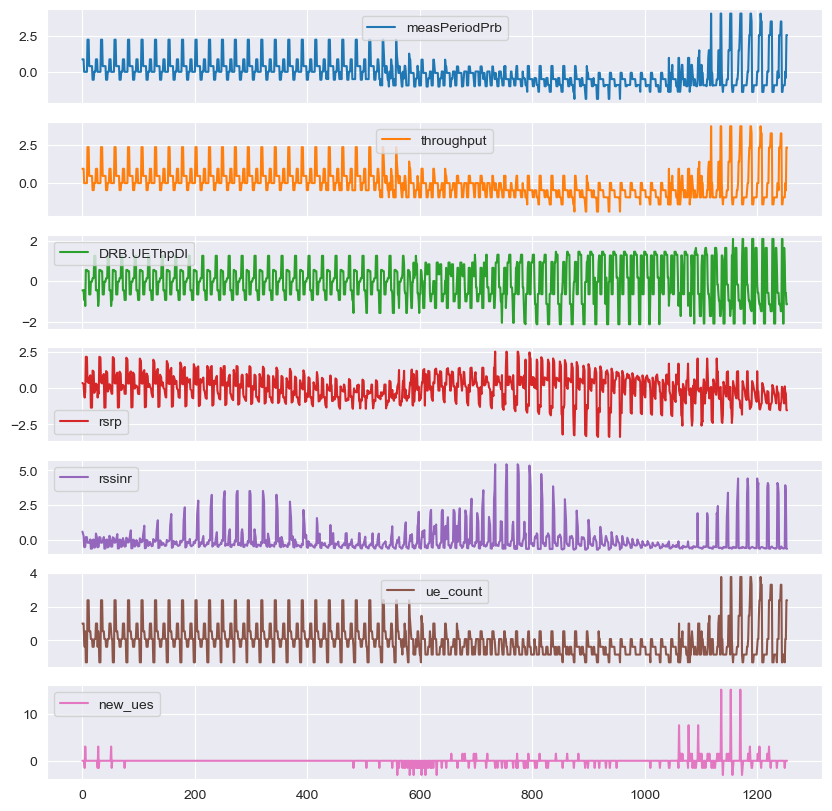

In [93]:
# plot data
import matplotlib.pyplot as plt
def plot_data(df, cell_id):
    df = df[df['nrCellIdentity']==cell_id]
    df = df.drop(columns=['step', 'nrCellIdentity', 'idx'])
    df.plot(subplots=True, figsize=(10, 10))
    plt.show()
plot_data(train, 5)

In [149]:
class DatasetLSTM(Dataset):
    def __init__(self, data):
        self.data = data
        self.max_idx = max(data['idx'])
    
    def __len__(self):
        return self.max_idx+1
    
    def __getitem__(self, idx):
        curr = self.data[self.data['idx']==idx]
        curr = curr.drop(columns=['step', 'idx', 'nrCellIdentity'])        
        numpy_array = curr.to_numpy()
        # convert to tensor
        tensor = torch.from_numpy(numpy_array).float()
        return tensor

sample = DatasetLSTM(train)[0]
print(sample.shape)
sample
        
        

torch.Size([3, 7])


tensor([[-2.8704e-01, -7.6273e-02,  3.6640e-01,  1.3220e+00,  1.7949e+00,
         -1.2492e-01, -1.5390e-03],
        [-2.8704e-01, -7.6273e-02,  3.6640e-01,  1.3677e+00,  1.5243e+00,
         -1.2492e-01, -1.5390e-03],
        [-2.8704e-01, -7.6273e-02,  3.6640e-01,  1.4079e+00,  1.2424e+00,
         -1.2492e-01, -1.5390e-03]])

# Training

In [ ]:
class EnsambleAE(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        pass

In [95]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super(LSTMAutoencoder, self).__init__()
        self.hidden_size = hidden_size
        self.encoder = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTM(input_size=hidden_size*2, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.output_layer = nn.Linear(hidden_size*2, input_size)  # Added linear layer to match input size

    def forward(self, x):
        x, _ = self.encoder(x)
        x, _ = self.decoder(x)
        x = self.output_layer(x)  # Map the hidden states back to the input feature space
        return x

In [96]:
batch_size = 1
lr = 0.0001      # learning rate
w_d = 1e-5        # weight decay
epochs = 200

input_size = 4 if only_cell else 7 # Number of features
hidden_size = 128  # Increased hidden size
num_layers = 3  # Increased number of layers
dropout = 0.1  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
metrics = defaultdict(list)
model = LSTMAutoencoder(input_size, hidden_size, num_layers, dropout)
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

print(f"in_features: {input_size}, hidden_size: {hidden_size}, num_layers: {num_layers}, dropout: {dropout}")
print(f"device: {device} criterion: {criterion} optimizer: {optimizer} epochs: {epochs} batch_size: {batch_size}")


train_set = DatasetLSTM(train)
test_set = DatasetLSTM(test)
train_loader = DataLoader(train_set,batch_size=batch_size)
test_loader = DataLoader(test_set,batch_size=batch_size)

in_features: 7, hidden_size: 128, num_layers: 3, dropout: 0.1
device: cpu criterion: MSELoss() optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 1e-05
) epochs: 200 batch_size: 1


NameError: name 'DatasetLSTM' is not defined

In [100]:
import time
model.train()
memo = set()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, data in enumerate(train_loader):
        data = data
        try:
            sample = model(data)
        except RuntimeError as e:
            memo.add(bx)
            continue
        loss = criterion(sample, data)
        
        # You can choose to skip this batch or take any other appropriate act
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
            
    epoch_loss = running_loss / len(train_loader)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    if epoch % 10 == 0 or epoch == epochs - 1:
        ep_end_10 = time.time()
        print('-----------------------------------------------')
        print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch + 1, epochs, epoch_loss))
        print(f'Epoch Complete in {ep_end - ep_start} | time for 10 eps {ep_end_10 - ep_start}' )
        

end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}m]'.format((end - start)/60))

-----------------------------------------------
[EPOCH] 1/200
[LOSS] 0.8305230926681599
Epoch Complete in 128.69611811637878 | time for 10 eps 128.69611811637878
-----------------------------------------------
[EPOCH] 11/200
[LOSS] 0.8294435916914948
Epoch Complete in 132.81631088256836 | time for 10 eps 132.81631088256836
-----------------------------------------------
[EPOCH] 21/200
[LOSS] 0.8294311643067241
Epoch Complete in 86.20053172111511 | time for 10 eps 86.20053172111511
-----------------------------------------------
[EPOCH] 31/200
[LOSS] 0.8294389538876079
Epoch Complete in 87.6372721195221 | time for 10 eps 87.6372721195221
-----------------------------------------------
[EPOCH] 41/200
[LOSS] 0.8294383598233288
Epoch Complete in 89.33729267120361 | time for 10 eps 89.33729267120361
-----------------------------------------------
[EPOCH] 51/200
[LOSS] 0.829444867702036
Epoch Complete in 103.98374772071838 | time for 10 eps 103.98374772071838
--------------------------------

KeyboardInterrupt: 

In [17]:
torch.save(model.state_dict(), f'models/cell_only_autoencoder_new.pth')

In [14]:
print(len(memo))
print(len(train_loader))

NameError: name 'memo' is not defined

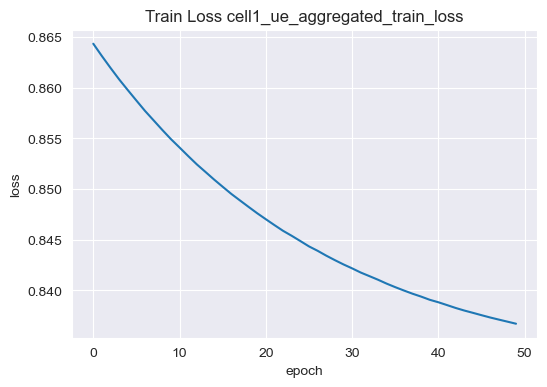

In [209]:
import matplotlib.pyplot as plt
def plot_loss(metrics, key, save=False, name='train_loss'):
    _, ax = plt.subplots(1,1,figsize=(6,4))
    ax.set_title(f"Train Loss {name}")
    ax.plot(metrics[key])
    plt.xlabel("epoch")
    plt.ylabel('loss')
    if save:
        plt.savefig(f'plots/{name}.png')
    plt.show()
plot_loss(metrics, "train_loss", save=True, name=f'cell{cell_id}_ue_aggregated_train_loss')

# Evaluation

## multiple cells model evaluation

In [43]:
cell_only = "cell_ue_aggregated_autoencoder.pth"
input_size = 7  # Number of features
hidden_size = 128  # Increased hidden size
num_layers = 3  # Increased number of layers
dropout = 0.1  
model = LSTMAutoencoder(input_size, hidden_size, num_layers, dropout)
model.load_state_dict(torch.load(f'models/{cell_only}', map_location=device))
model.to(device)

LSTMAutoencoder(
  (encoder): LSTM(7, 128, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (decoder): LSTM(256, 128, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (output_layer): Linear(in_features=256, out_features=7, bias=True)
)

In [44]:

anomaly = test[test['nrCellIdentity'] == 5]
normal = test[test['nrCellIdentity'] != 5]
anomaly_loader = DataLoader(DatasetLSTM(anomaly), batch_size=1)
normal_loader = DataLoader(DatasetLSTM(normal), batch_size=1)
loss_dist_normal = []
loss_dist_anomaly = []

memo_ano = set()
memo_normal = set()
memo = set()

model.eval()
with torch.no_grad():
    for bx, data in enumerate(normal_loader):
        try:
            sample = model(data)
        except RuntimeError as e:
            memo.add(bx)
            continue
        loss = criterion(sample, data)
        loss_dist_normal.append(loss.item())
    
    for bx, data in enumerate(anomaly_loader):
        try:
            sample = model(data)
        except RuntimeError as e:
            memo.add(bx)
            continue
        loss = criterion(sample, data)
        loss_dist_anomaly.append(loss.item())
   

## single cell evaluation  

590
118


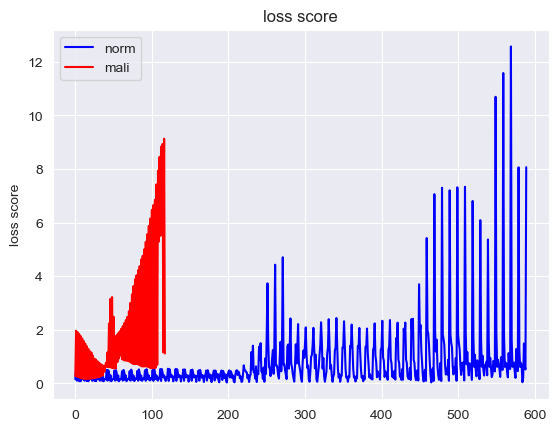

In [45]:
len(loss_dist_normal), len(loss_dist_anomaly)
print(len(loss_dist_normal))
print(len(loss_dist_anomaly))
plt.title("loss score")
plt.plot(loss_dist_normal, label='norm', color='blue')
plt.plot(loss_dist_anomaly, label='mali', color='red')
plt.legend()
plt.ylabel("loss score")
plt.grid(1)
plt.show()

Best Threshold: 0.64
Best F1 Score: 0.45


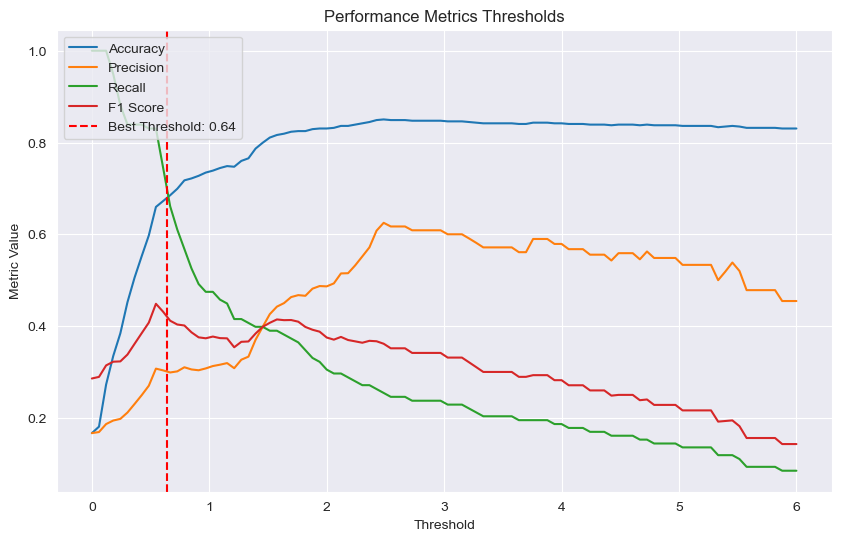

In [47]:
import numpy as np
thresholds = np.linspace(0, 6, 100)  # Range of threshold values to test
best_threshold = 0
best_f1_score = 0
metrics = []

for threshold in thresholds:
    tp = fp = tn = fn = 0
    
    for loss in loss_dist_normal:
        if loss > threshold:
            fp += 1
        else:
            tn += 1

    for loss in loss_dist_anomaly:
        if loss > threshold:
            tp += 1
        else:
            fn += 1

    # Calculate metrics
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    balanced_accuracy = (recall + tn / (tn + fp)) / 2

    metrics.append((threshold, accuracy, precision, recall, f1_score, balanced_accuracy))

    # Check if this threshold gives the best F1 score
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_threshold = threshold
best_threshold = 0.64
# Print the best threshold and corresponding metrics
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1_score:.2f}")

# Plot the metrics as a function of the threshold
metrics = np.array(metrics)
plt.figure(figsize=(10, 6))
plt.plot(metrics[:, 0], metrics[:, 1], label='Accuracy')
plt.plot(metrics[:, 0], metrics[:, 2], label='Precision')
plt.plot(metrics[:, 0], metrics[:, 3], label='Recall')
plt.plot(metrics[:, 0], metrics[:, 4], label='F1 Score')
# plt.plot(metrics[:, 0], metrics[:, 5], label='Balanced Accuracy')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.title('Performance Metrics Thresholds')
plt.savefig(f'plots/cell{cell_id}_ue_aggregated_performance_metrics_thresholds.png')
plt.show()

Accuracy: 0.68
Precision: 0.30
Recall: 0.68
F1 Score: 0.41
Balanced Accuracy: 0.68


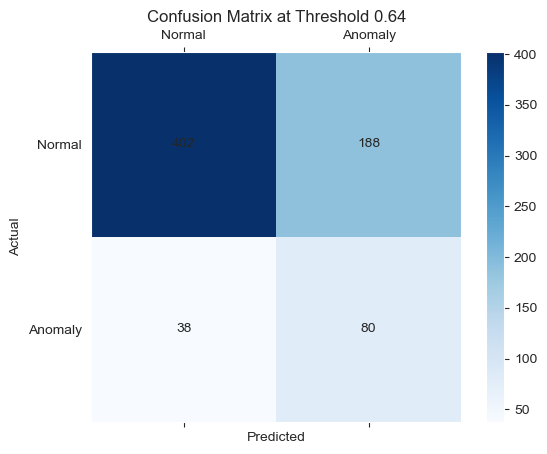

In [49]:

# best_threshold = 0.9
# Plot confusion matrix for the best threshold
tp = fp = tn = fn = 0
for loss in loss_dist_normal:
    if loss > best_threshold:
        fp += 1
    else:
        tn += 1

for loss in loss_dist_anomaly:
    if loss > best_threshold:
        tp += 1
    else:
        fn += 1

confusion_matrix = np.array([[tn, fp], [fn, tp]])

fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)

for (i, j), val in np.ndenumerate(confusion_matrix):
    ax.text(j, i, f'{val}', ha='center', va='center')

precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
accuracy = (tp + tn) / (tp + fp + tn + fn)
balanced_accuracy = (recall + tn / (tn + fp)) / 2

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.yticks([0, 1], ['Normal', 'Anomaly'])
plt.title(f'Confusion Matrix at Threshold {best_threshold:.2f}')
plt.grid(0)
plt.savefig(f'plots/cell_ue.png')
plt.show()


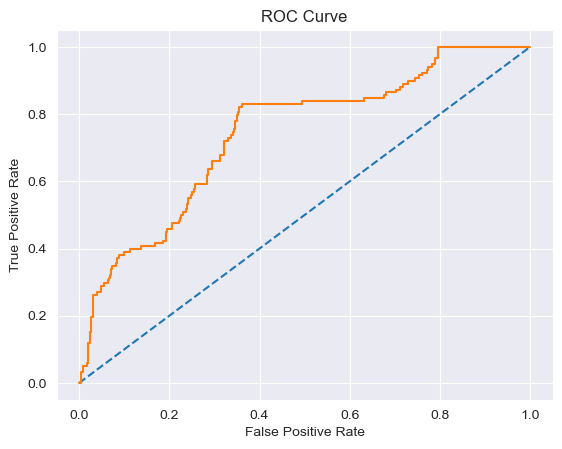

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve([0]*len(loss_dist_normal) + [1]*len(loss_dist_anomaly), loss_dist_normal + loss_dist_anomaly)
# plot x=y line
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(1)
plt.savefig(f'plots/cell_ue_aggregated_roc_curve.png')
plt.show()

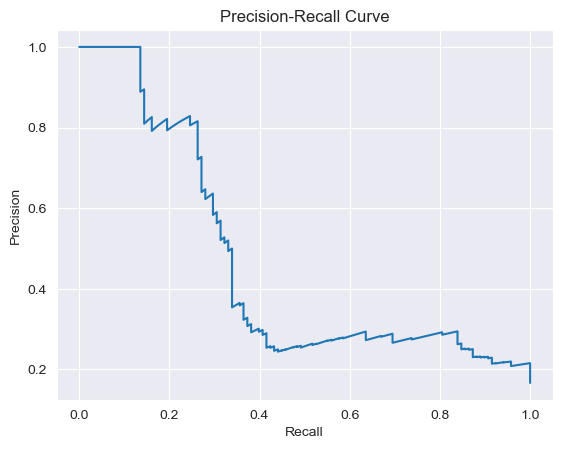

In [34]:
# precision-recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve([0]*len(loss_dist_normal) + [1]*len(loss_dist_anomaly), loss_dist_normal + loss_dist_anomaly)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(1)
plt.show()


In [130]:
# load model from /models folder
# model_name = f'cell{cell_id}_only_ue_aggregated_autoencoder.pth'
# print("loading model: ", model_name)
# model = LSTMAutoencoder(input_size, hidden_size, num_layers, dropout)
# model.load_state_dict(torch.load(f'models/{model_name}', map_location=device))
# model.to(device)

cell_agg = "cell_ue_aggregated_autoencoder.pth"
model = LSTMAutoencoder(input_size, hidden_size, num_layers, dropout)
model.load_state_dict(torch.load(f'models/{cell_agg}', map_location=device))
model.to(device)

LSTMAutoencoder(
  (encoder): LSTM(7, 128, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (decoder): LSTM(256, 128, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (output_layer): Linear(in_features=256, out_features=7, bias=True)
)

In [59]:
# load model from /models folder
model_name = f'cell{cell_id}_only_ue_aggregated_autoencoder.pth'
print("loading model: ", model_name)
model = LSTMAutoencoder(input_size, hidden_size, num_layers, dropout)
model.load_state_dict(torch.load(f'models/{model_name}', map_location=device))
model.to(device)


loading model:  cell5_only_ue_aggregated_autoencoder.pth


LSTMAutoencoder(
  (encoder): LSTM(7, 128, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (decoder): LSTM(256, 128, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (output_layer): Linear(in_features=256, out_features=7, bias=True)
)

In [75]:
cell_m

,time,availPrbDl,availPrbUl,measPeriodPdcpBytes,measPeriodPrb,measTimeStampRf,nrCellIdentity,pdcpBytesDl,pdcpBytesUl,step,throughput,x,y
0,2024-05-28T12:56:50.136301Z,2,5,65,360,2024-05-28 12:56:50.131157,1,201.992067,201.992067,0,201.992067,250,300
1,2024-05-28T12:56:50.563541Z,8,5,14,300,2024-05-28 12:56:50.131187,2,177.417067,177.417067,0,177.417067,500,125
2,2024-05-28T12:56:50.983010Z,95,15,1,276,2024-05-28 12:56:50.131194,3,151.752423,151.752423,0,151.752423,750,300
3,2024-05-28T12:56:51.400989Z,9,42,4,563,2024-05-28 12:56:50.131200,4,329.668759,329.668759,0,329.668759,750,700
4,2024-05-28T12:56:51.824846Z,11,57,48,250,2024-05-28 12:56:50.131356,5,161.300502,161.300502,0,161.300502,500,875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2024-05-28T13:36:03.122455Z,11,70,50,87,2024-05-28 13:36:02.697465,2,50.778295,50.778295,59,50.778295,500,125
356,2024-05-28T13:36:03.541699Z,31,70,8,348,2024-05-28 13:36:02.697474,3,202.385533,202.385533,59,202.385533,750,300
357,2024-05-28T13:36:03.961463Z,69,86,69,130,2024-05-28 13:36:02.697481,4,75.817149,75.817149,59,75.817149,750,700
358,2024-05-28T13:36:04.379925Z,97,29,93,808,2024-05-28 13:36:02.697624,5,1053.209206,1053.209206,59,1053.209206,500,875


In [76]:
# load data for evaluation
# mali data
cell_id = 5
ue_test_mali = ue_m
cell_test_mali = cell_m

# normal data
ue_test_norm = pd.read_csv('data/ue_norm_seed_8.csv')
cell_test_norm = pd.read_csv('data/cell_norm_seed_8.csv')
# process  
mali_dfs = get_dfs([ue_test_mali], [cell_test_mali])
norm_dfs = get_dfs([ue_test_norm], [cell_test_norm])
# extract features
mali_dfs = features_extraction(mali_dfs, only_cell=only_cell, single_cell=cell_id)
norm_dfs = features_extraction(norm_dfs, only_cell=only_cell, single_cell=cell_id)
# create indexes for evaluation 
mali_test = create_idxs(mali_dfs, win_size=3, only_cell=cell_id)
norm_test = create_idxs(norm_dfs, win_size=3, only_cell=cell_id)
# scale using the train scaler
mali_test, _ = scale_df(mali_test, test=True, scaler=scaler)
norm_test, _ = scale_df(norm_test, test=True, scaler=scaler)


In [78]:
norm_dfs[0].head(3)

,step,nrCellIdentity,measPeriodPrb,throughput,DRB.UEThpDl,rsrp,rssinr,ue_count,new_ues
4,0,5,89.0,50.742996,25.371498,-63.863185,6.812758e+09,2,0
10,1,5,89.0,50.742996,25.371498,-64.245774,6.096037e+09,2,0
16,2,5,89.0,50.742996,25.371498,-64.623937,5.462660e+09,2,0


In [79]:
mali_dataset = DatasetLSTM(mali_test)
norm_dataset = DatasetLSTM(norm_test)
mali_loader = DataLoader(mali_dataset, batch_size=1)
norm_loader = DataLoader(norm_dataset, batch_size=1)

In [80]:
loss_dist_normal = []
loss_dist_anomaly = []

memo_ano = set()
memo_normal = set()

model.eval()
with torch.no_grad():
    for bx, data in enumerate(norm_loader):
        try:
            sample = model(data)
        except RuntimeError as e:
            memo.add(bx)
            continue
        loss = criterion(sample, data)
        loss_dist_normal.append(loss.item())
    
    for bx, data in enumerate(mali_loader):
        try:
            sample = model(data)
        except RuntimeError as e:
            memo.add(bx)
            continue
        loss = criterion(sample, data)
        loss_dist_anomaly.append(loss.item())
   

24
59


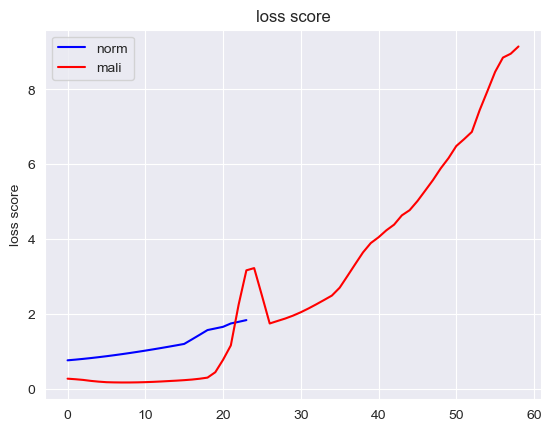

In [81]:
print(len(loss_dist_normal))
print(len(loss_dist_anomaly))
plt.title("loss score")
plt.plot(loss_dist_normal, label='norm', color='blue')
plt.plot(loss_dist_anomaly, label='mali', color='red')
plt.legend()
plt.ylabel("loss score")
plt.grid(1)
plt.show()

## Thresholding

Best Threshold: 1.70
Best F1 Score: 0.83


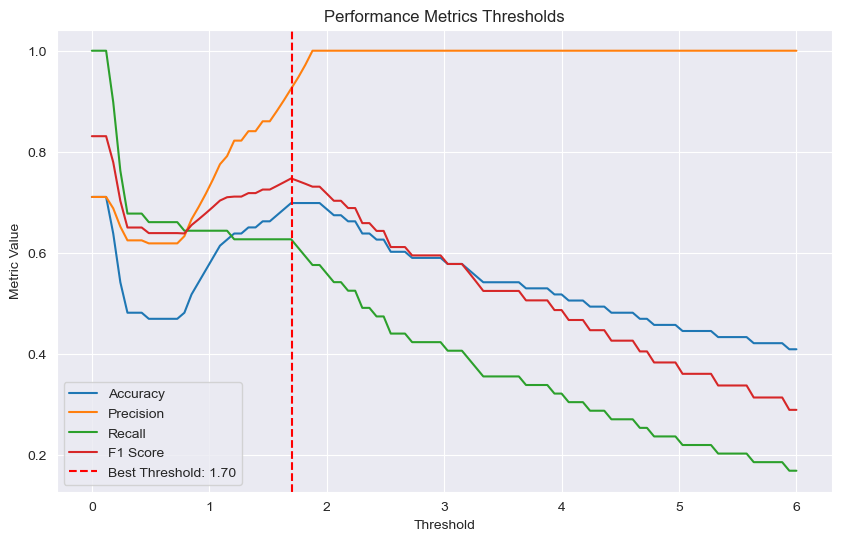

In [85]:
import numpy as np
thresholds = np.linspace(0, 6, 100)  # Range of threshold values to test
best_threshold = 0
best_f1_score = 0
metrics = []

for threshold in thresholds:
    tp = fp = tn = fn = 0
    
    for loss in loss_dist_normal:
        if loss > threshold:
            fp += 1
        else:
            tn += 1

    for loss in loss_dist_anomaly:
        if loss > threshold:
            tp += 1
        else:
            fn += 1

    # Calculate metrics
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    balanced_accuracy = (recall + tn / (tn + fp)) / 2

    metrics.append((threshold, accuracy, precision, recall, f1_score, balanced_accuracy))

    # Check if this threshold gives the best F1 score
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_threshold = threshold
best_threshold =1.7
# Print the best threshold and corresponding metrics
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1_score:.2f}")

# Plot the metrics as a function of the threshold
metrics = np.array(metrics)
plt.figure(figsize=(10, 6))
plt.plot(metrics[:, 0], metrics[:, 1], label='Accuracy')
plt.plot(metrics[:, 0], metrics[:, 2], label='Precision')
plt.plot(metrics[:, 0], metrics[:, 3], label='Recall')
plt.plot(metrics[:, 0], metrics[:, 4], label='F1 Score')
# plt.plot(metrics[:, 0], metrics[:, 5], label='Balanced Accuracy')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.title('Performance Metrics Thresholds')
plt.savefig(f'plots/cell{cell_id}_ue_aggregated_performance_metrics_thresholds.png')
plt.show()

Accuracy: 0.70
Precision: 0.93
Recall: 0.63
F1 Score: 0.75
Balanced Accuracy: 0.75


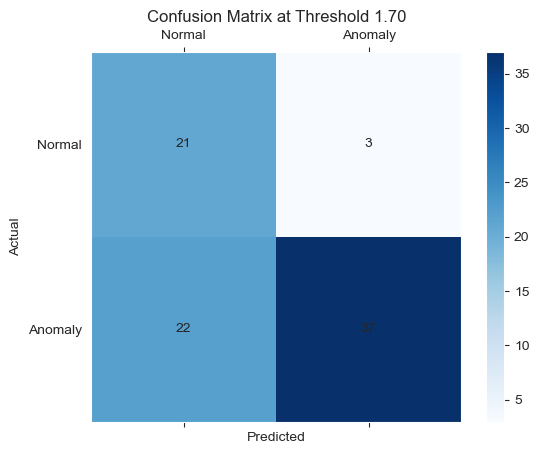

In [86]:

# best_threshold = 0.9
# Plot confusion matrix for the best threshold
tp = fp = tn = fn = 0
for loss in loss_dist_normal:
    if loss > best_threshold:
        fp += 1
    else:
        tn += 1

for loss in loss_dist_anomaly:
    if loss > best_threshold:
        tp += 1
    else:
        fn += 1

confusion_matrix = np.array([[tn, fp], [fn, tp]])

fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)

for (i, j), val in np.ndenumerate(confusion_matrix):
    ax.text(j, i, f'{val}', ha='center', va='center')

precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
accuracy = (tp + tn) / (tp + fp + tn + fn)
balanced_accuracy = (recall + tn / (tn + fp)) / 2

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.yticks([0, 1], ['Normal', 'Anomaly'])
plt.title(f'Confusion Matrix at Threshold {best_threshold:.2f}')
plt.grid(0)
plt.savefig(f'plots/single_cell{cell_id}.png')
plt.show()


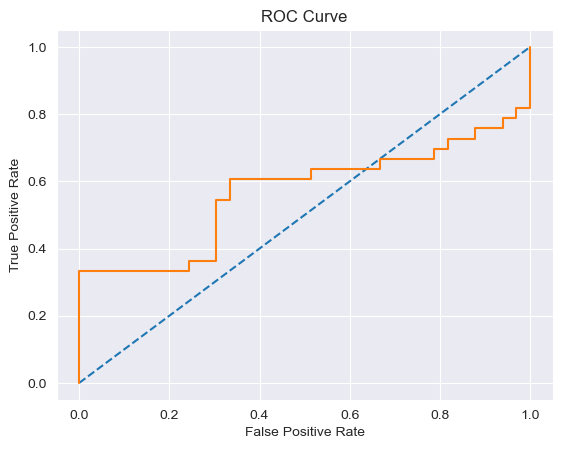

In [94]:
# plot AUC curve 
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve([0]*len(loss_dist_normal) + [1]*len(loss_dist_anomaly), loss_dist_normal + loss_dist_anomaly)
# plot x=y line
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(1)
plt.show()


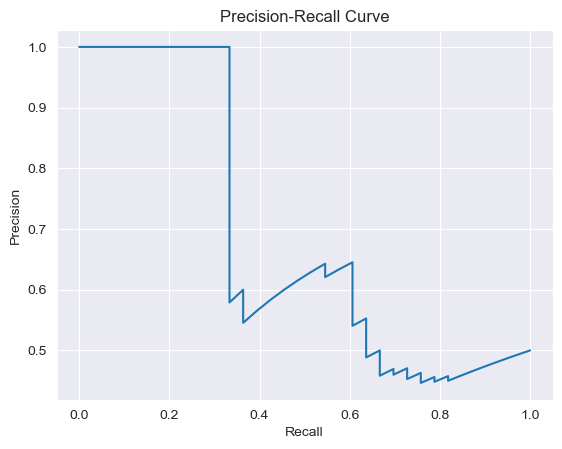

In [93]:
# precision-recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve([0]*len(loss_dist_normal) + [1]*len(loss_dist_anomaly), loss_dist_normal + loss_dist_anomaly)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(1)
plt.show()

In [225]:
anomaly = test[test['nrCellIdentity']==5]
normal = norm_test[norm_test['nrCellIdentity']==5]
anomaly_loader = DataLoader(DatasetLSTM(anomaly), batch_size=1)
normal_loader = DataLoader(DatasetLSTM(normal), batch_size=1)

In [226]:

loss_dist_normal = []
loss_dist_anomaly = []

memo_ano = set()
memo_normal = set()

model.eval()
with torch.no_grad():
    for bx, data in enumerate(normal_loader):
        try:
            sample = model(data)
        except RuntimeError as e:
            memo.add(bx)
            continue
        loss = criterion(sample, data)
        loss_dist_normal.append(loss.item())
    
    for bx, data in enumerate(anomaly_loader):
        try:
            sample = model(data)
        except RuntimeError as e:
            memo.add(bx)
            continue
        loss = criterion(sample, data)
        loss_dist_anomaly.append(loss.item())
   

In [35]:
print(len(loss_dist_normal))
print(len(loss_dist_anomaly))

33
33


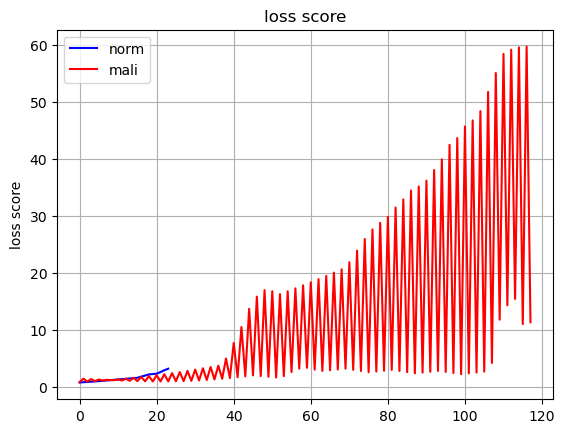

In [228]:
plt.title("loss score")
plt.plot(loss_dist_normal, label='norm', color='blue')
plt.plot(loss_dist_anomaly, label='mali', color='red')
plt.legend()
plt.ylabel("loss score")
plt.grid(1)
plt.show()

In [33]:
import numpy as np
import matplotlib.pyplot as plt


thresholds = np.linspace(0, 6, 100)  # Range of threshold values to test
best_threshold = 0
best_f1_score = 0
metrics = []

for threshold in thresholds:
    tp = fp = tn = fn = 0
    
    for loss in loss_dist_normal:
        if loss > threshold:
            fp += 1
        else:
            tn += 1

    for loss in loss_dist_anomaly:
        if loss > threshold:
            tp += 1
        else:
            fn += 1

    # Calculate metrics
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    balanced_accuracy = (recall + tn / (tn + fp)) / 2

    metrics.append((threshold, accuracy, precision, recall, f1_score, balanced_accuracy))

    # Check if this threshold gives the best F1 score
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_threshold = threshold

# Print the best threshold and corresponding metrics
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1_score:.2f}")

# Plot the metrics as a function of the threshold
metrics = np.array(metrics)
plt.figure(figsize=(10, 6))
plt.plot(metrics[:, 0], metrics[:, 1], label='Accuracy')
plt.plot(metrics[:, 0], metrics[:, 2], label='Precision')
plt.plot(metrics[:, 0], metrics[:, 3], label='Recall')
plt.plot(metrics[:, 0], metrics[:, 4], label='F1 Score')
plt.plot(metrics[:, 0], metrics[:, 5], label='Balanced Accuracy')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.title('Performance Metrics Thresholds')
plt.savefig('plots/cell_ue_aggregated_performance_metrics_thresholds.png')
plt.show()

# Plot confusion matrix for the best threshold
tp = fp = tn = fn = 0
for loss in loss_dist_normal:
    if loss > best_threshold:
        fp += 1
    else:
        tn += 1

for loss in loss_dist_anomaly:
    if loss > best_threshold:
        tp += 1
    else:
        fn += 1

confusion_matrix = np.array([[tn, fp], [fn, tp]])

fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)

for (i, j), val in np.ndenumerate(confusion_matrix):
    ax.text(j, i, f'{val}', ha='center', va='center')

precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
accuracy = (tp + tn) / (tp + fp + tn + fn)
balanced_accuracy = (recall + tn / (tn + fp)) / 2

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.yticks([0, 1], ['Normal', 'Anomaly'])
plt.title(f'Confusion Matrix at Threshold {best_threshold:.2f}')
plt.show()

NameError: name 'loss_dist_normal' is not defined

In [97]:
import seaborn as sns
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
threshold=2.4

for loss in loss_dist_normal:
    if loss > threshold:
        fp += 1
    else:
        tn += 1

for loss in loss_dist_anomaly:
    if loss > threshold:
        tp += 1
    else:
        fn += 1
print(f"tp: {tp}, fp: {fp}, tn: {tn}, fn: {fn}")

Accuracy: 0.89
Precision: 0.69
Recall: 0.61
F1 Score: 0.65
Balanced Accuracy: 0.78


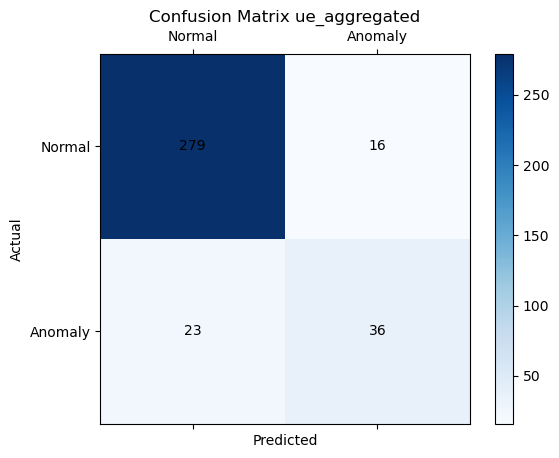

In [99]:
import numpy as np
accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
balanced_accuracy = (recall + tn / (tn + fp)) / 2
# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

# Plot confusion matrix
confusion_matrix = np.array([[tn, fp], [fn, tp]])

fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)

for (i, j), val in np.ndenumerate(confusion_matrix):
    ax.text(j, i, f'{val}', ha='center', va='center')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.yticks([0, 1], ['Normal', 'Anomaly'])
plt.title(f'Confusion Matrix ue_aggregated')

plt.savefig('plots/cell_ue_aggregated__confusion_matrix.png')
plt.show()

In [150]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super(LSTMAutoencoder, self).__init__()
        self.hidden_size = hidden_size
        self.encoder = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTM(input_size=hidden_size*2, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.output_layer = nn.Linear(hidden_size*2, input_size)  # Added linear layer to match input size

    def forward(self, x):
        x, _ = self.encoder(x)
        x, _ = self.decoder(x)
        x = self.output_layer(x)  # Map the hidden states back to the input feature space
        return x

In [167]:
# load all single cell models
def load_single_cell_models_and_data(data_frame):
    input_size = 7
    single_cell_models = []
    for i in range(1, 7):
        model_name = f'cell{i}_only_ue_aggregated_autoencoder.pth'
        print("loading model: ", model_name)
        model = LSTMAutoencoder(input_size, hidden_size, num_layers, dropout)
        model.load_state_dict(torch.load(f'models/{model_name}', map_location=device))
        model.to(device)
        single_cell_models.append(model)
    #  get data loaders for all cells trainng data
    cell_loaders = []
    for i in range(1, 7):
        cell = data_frame[data_frame['nrCellIdentity']==i]
        dataset = DatasetLSTM(cell)
        print(len(dataset))
        cell_loader = DataLoader(dataset, batch_size=1)
        cell_loaders.append(cell_loader)
    return single_cell_models, cell_loaders

def get_latent_space(single_cell_models, cell_loaders):
    latent_space = {}
    hs = []
    for i, model in enumerate(single_cell_models):
        cell_loader = cell_loaders[i]
        latent = []
        model.eval()
        with torch.no_grad():
            for bx, data in enumerate(cell_loader):
                try:
                    sample, h = model.encoder(data)
                except RuntimeError as e:
                    continue
                latent.append((data, sample))
                hs.append(h)
        latent_space[f'{i+1}'] = latent
    return latent_space



In [188]:
class LSTMDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, cell_id, dropout=0.1):
        super(LSTMDecoder, self).__init__()
        self.cell_id = cell_id if isinstance(cell_id, str) else str(cell_id)
        self.hidden_size = hidden_size
        # input is latent space of cell (1, 3, 256) cat with avg of other cells (1, 3, 256) overall (1, 3, 512)
        self.decoder = nn.LSTM(input_size=hidden_size*2, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size)
        self.output_layer = nn.Linear(hidden_size, input_size)  # Added linear layer to match input size
    
        
    def make_input(self, embeddings): 
        x = embeddings[self.cell_id]
        other_tensors = [tensor for k, tensor in embeddings.items() if k != key]
        avg_tensor = torch.mean(torch.stack(other_tensors), dim=0)
        x = torch.cat((x, avg_tensor), dim=-1)
        # print(x.size())
        return x.squeeze(0)    
        
        
    def forward(self, x):
        x = self.make_input(x)
        x, _ = self.decoder(x)
        x = self.fc(x)
        x = self.output_layer(x)  # Map the hidden states back to the input feature space
        return x

In [204]:
class DatasetDecoder(Dataset):
    def __init__(self,data, cell_id):
        if not isinstance(cell_id, str):
            cell_id = str(cell_id)
        self.data = data
        self.cell_id = cell_id
        # self.max_idx = max(data['idx'])
    
    def __len__(self):
        lens = [len(self.data[id]) for id in ['1', '2', '3', '4', '5', '6']]
        return min(lens)
    
    def __getitem__(self, idx):
        y = self.data[self.cell_id][idx][0].squeeze(0)
        x = {}
        for id in ['1', '2', '3', '4', '5', '6']:
            x[id] = self.data[id][idx][1]
        return x ,y

432


In [190]:
single_cell_models, cell_loaders = load_single_cell_models_and_data(train)
latent_space = get_latent_space(single_cell_models, cell_loaders)

loading model:  cell1_only_ue_aggregated_autoencoder.pth
loading model:  cell2_only_ue_aggregated_autoencoder.pth
loading model:  cell3_only_ue_aggregated_autoencoder.pth
loading model:  cell4_only_ue_aggregated_autoencoder.pth
loading model:  cell5_only_ue_aggregated_autoencoder.pth
loading model:  cell6_only_ue_aggregated_autoencoder.pth
3256
3264
3272
3280
3288
3296


In [191]:
input_size

7

In [222]:
# train only cell_id 1
cell_id = 5
batch_size = 1
lr = 0.0001      # learning rate
w_d = 1e-5        # weight decay
epochs = 50

input_size = 4 if only_cell else 7 # Number of features
hidden_size = 128  # Increased hidden size
num_layers = 3  # Increased number of layers
dropout = 0.1  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
metrics = defaultdict(list)
decoder = LSTMDecoder(input_size, hidden_size*2, num_layers, cell_id)
decoder.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(decoder.parameters(), lr=lr, weight_decay=w_d)

print(f"in_features: {input_size}, hidden_size: {hidden_size}, num_layers: {num_layers}, dropout: {dropout}")
print(f"device: {device} criterion: {criterion} optimizer: {optimizer} epochs: {epochs} batch_size: {batch_size}")

train_set = DatasetDecoder(latent_space, cell_id)
print(len(train_set))
train_loader = DataLoader(train_set,batch_size=batch_size)

in_features: 7, hidden_size: 128, num_layers: 3, dropout: 0.1
device: cpu criterion: MSELoss() optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 1e-05
) epochs: 50 batch_size: 1
423


In [223]:
import time
decoder.train()
memo = set()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, (data, label) in enumerate(train_loader):
        data = data
        try:
            sample = decoder(data)
            
        except RuntimeError as e:
            memo.add(bx)
            continue
        # break
        loss = criterion(sample, label)
        
        # You can choose to skip this batch or take any other appropriate act
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # break
            
    epoch_loss = running_loss / len(train_loader)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    if epoch % 10 == 0 or epoch == epochs - 1:
        ep_end_10 = time.time()
        print('-----------------------------------------------')
        print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch + 1, epochs, epoch_loss))
        print(f'Epoch Complete in {ep_end - ep_start} | time for 10 eps {ep_end_10 - ep_start}' )
        

end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}m]'.format((end - start)/60))

-----------------------------------------------
[EPOCH] 1/50
[LOSS] 0.9476172855876862
Epoch Complete in 23.962038040161133 | time for 10 eps 23.962038040161133
-----------------------------------------------
[EPOCH] 11/50
[LOSS] 0.8032363730859249
Epoch Complete in 40.369200468063354 | time for 10 eps 40.369200468063354
-----------------------------------------------
[EPOCH] 21/50
[LOSS] 0.6992606437163995
Epoch Complete in 29.485093355178833 | time for 10 eps 29.485093355178833
-----------------------------------------------
[EPOCH] 31/50
[LOSS] 0.6250960541312224
Epoch Complete in 58.42071723937988 | time for 10 eps 58.42071723937988
-----------------------------------------------
[EPOCH] 41/50
[LOSS] 0.5745153963988554
Epoch Complete in 97.01248288154602 | time for 10 eps 97.01248288154602
-----------------------------------------------
[EPOCH] 50/50
[LOSS] 0.544849864359126
Epoch Complete in 140.43673491477966 | time for 10 eps 140.43673491477966
----------------------------------

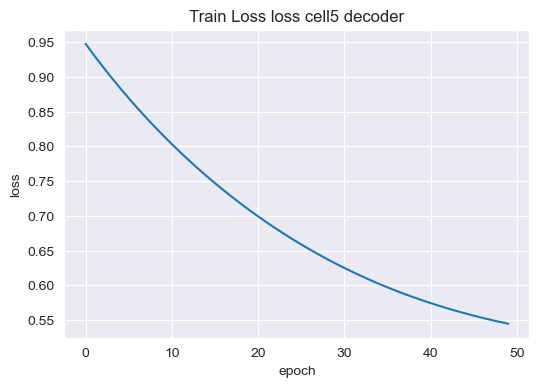

In [224]:
plot_loss(metrics, "train_loss", save=True, name=f'loss cell{cell_id} decoder')

In [225]:
# save model
torch.save(decoder.state_dict(), f'models/cell{cell_id}_eps{epochs}_decoder.pth')

In [226]:
single_cell_models, cell_loaders = load_single_cell_models_and_data(test)
latent_space = get_latent_space(single_cell_models, cell_loaders)

loading model:  cell1_only_ue_aggregated_autoencoder.pth
loading model:  cell2_only_ue_aggregated_autoencoder.pth
loading model:  cell3_only_ue_aggregated_autoencoder.pth
loading model:  cell4_only_ue_aggregated_autoencoder.pth
loading model:  cell5_only_ue_aggregated_autoencoder.pth
loading model:  cell6_only_ue_aggregated_autoencoder.pth
814
816
818
820
822
824


In [228]:
nor_loss_dist = []
ano_loss_dist = []
memo = set()
decoder.eval()
with torch.no_grad():
    for i in range(1, 7):
        cell_loader = DataLoader(DatasetDecoder(latent_space, i), batch_size=1)
        for bx, (data, label) in enumerate(cell_loader):
            try:
                sample = decoder(data)
            except RuntimeError as e:
                memo.add(bx)
                continue
            loss = criterion(sample, label)
            if i == 5:
                ano_loss_dist.append(loss.item())
            else:
                nor_loss_dist.append(loss.item())
print(f"len normal: {len(nor_loss_dist)} len anomaly: {len(ano_loss_dist)}")

len normal: 590 len anomaly: 118


In [237]:
# evaluate the decoder
def find_best_threshold(normal_loss, anomaly_loss, name='',save=False):
    thresholds = np.linspace(0, 6, 100)  # Range of threshold values to test
    best_threshold = 0
    best_f1_score = 0
    metrics = []
    
    for threshold in thresholds:
        tp = fp = tn = fn = 0
        
        for loss in normal_loss:
            if loss > threshold:
                fp += 1
            else:
                tn += 1
    
        for loss in anomaly_loss:
            if loss > threshold:
                tp += 1
            else:
                fn += 1
    
        # Calculate metrics
        accuracy = (tp + tn) / (tp + fp + tn + fn)
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        balanced_accuracy = (recall + tn / (tn + fp)) / 2
    
        metrics.append((threshold, accuracy, precision, recall, f1_score, balanced_accuracy))
    
        # Check if this threshold gives the best F1 score
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_threshold = threshold
    # best_threshold =1.7
    # Print the best threshold and corresponding metrics
    print(f"Best Threshold: {best_threshold:.2f}")
    print(f"Best F1 Score: {best_f1_score:.2f}")
    
    # Plot the metrics as a function of the threshold
    metrics = np.array(metrics)
    plt.figure(figsize=(10, 6))
    plt.plot(metrics[:, 0], metrics[:, 1], label='Accuracy')
    plt.plot(metrics[:, 0], metrics[:, 2], label='Precision')
    plt.plot(metrics[:, 0], metrics[:, 3], label='Recall')
    plt.plot(metrics[:, 0], metrics[:, 4], label='F1 Score')
    # plt.plot(metrics[:, 0], metrics[:, 5], label='Balanced Accuracy')
    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.title('Performance Metrics Thresholds')
    if save:
        plt.savefig(f'plots/{name}_performance_metrics_thresholds.png')
    plt.show()
    return best_threshold

In [243]:
def plot_confusion_matrix(loss_dist_normal, loss_dist_anomaly, best_threshold, name='cell', save=False, verbose=True):
    tp = fp = tn = fn = 0
    for loss in loss_dist_normal:
        if loss > best_threshold:
            fp += 1
        else:
            tn += 1
    
    for loss in loss_dist_anomaly:
        if loss > best_threshold:
            tp += 1
        else:
            fn += 1
    # confusion matrix as percentage
    
    
    confusion_matrix = np.array([[tn, fp], [fn, tp]])
    
    fig, ax = plt.subplots()
    cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    for (i, j), val in np.ndenumerate(confusion_matrix):
        ax.text(j, i, f'{val}', ha='center', va='center')
    
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    balanced_accuracy = (recall + tn / (tn + fp)) / 2
    
    result = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score,
        "Balanced Accuracy": balanced_accuracy
    }
    if verbose:
        print(result)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0, 1], ['Normal', 'Anomaly'])
    plt.yticks([0, 1], ['Normal', 'Anomaly'])
    plt.title(f'Confusion Matrix at Threshold {best_threshold:.2f}')
    plt.grid(0)
    if save:
        plt.savefig(f'plots/{name}_confusion_matrix.png')
    plt.show()
    return result


Best Threshold: 2.73
Best F1 Score: 0.38


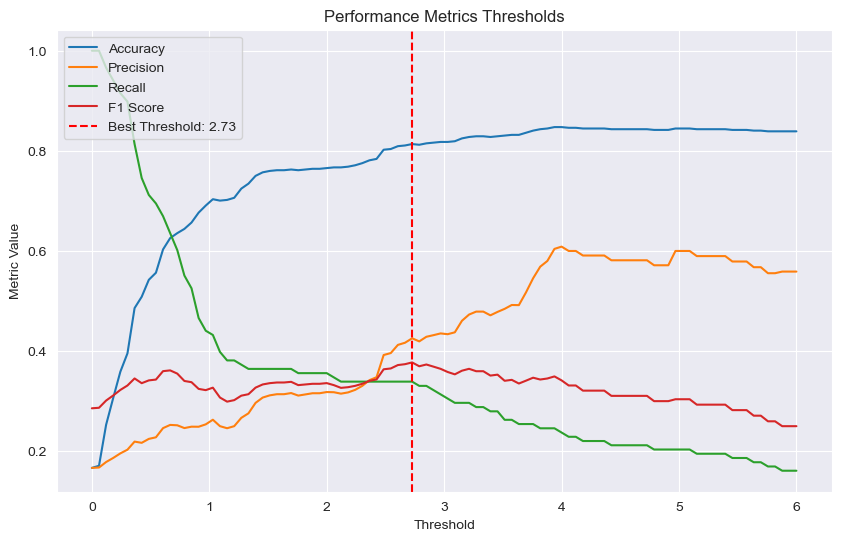

In [238]:
best_threshold = find_best_threshold(nor_loss_dist, ano_loss_dist, name='cell5', save=True)


{'Accuracy': 0.8135593220338984, 'Precision': 0.425531914893617, 'Recall': 0.3389830508474576, 'F1 Score': 0.3773584905660377, 'Balanced Accuracy': 0.623728813559322}


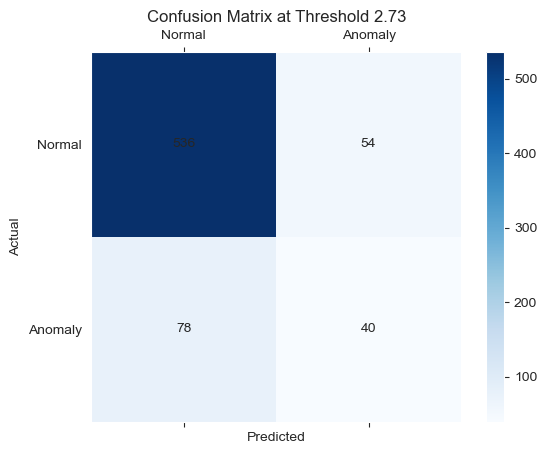

{'Accuracy': 0.8135593220338984,
 'Precision': 0.425531914893617,
 'Recall': 0.3389830508474576,
 'F1 Score': 0.3773584905660377,
 'Balanced Accuracy': 0.623728813559322}

In [244]:
plot_confusion_matrix(nor_loss_dist, ano_loss_dist, best_threshold, name='cell5', save=True)